In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle


# Q-Tables

| Partner Selection  | LEAVE | STAY |
| :----------------- | :---: | :--: |
| PARTNER_DEFECTED   | 0     | 0    |
| PARTNER_COOPERATED | 0     | 0    |

`LEAVE` and `STAY` are the two actions in the partner selection stage.  
If two agents are paired and one agent chooses to leave then both agents will be added to a pool. 
After all agents have made their choices agents in the pool are randomly paired. 
If both agents choose to stay then they will remain paired for the prisoner's dilemma stage.

| Prisoner's Dilemma  | DEFECT | COOPERATE |
| :------------------ | :----: | :-------: |
| PARTNER_DEFECTED    | 0      | 0         |
| PARTNER_COOPERATED  | 0      | 0         |

`DEFECT` and `COOPERATE` are the two actions in the prisoner's dilemma stage.
Agents are given rewards in the prisoner's dilemma stage which can be seen in the table below 
where ($r_i$, $r_j$) is the returned rewards for agents `i` and `j`

|                    | `j` Defects | `j` Cooperates |
| ------------------ | ----------- | -------------- |
| **`i` Defects**    | (1, 1)      | (5, 0)         |
| **`i` Cooperates** | (0, 5)      | (3, 3)         |

In [3]:
from enum import Enum

class ActionPS(Enum):
    LEAVE = 0
    STAY = 1

class ActionPD(Enum):
    DEFECT = 0
    COOPERATE = 1

class State(Enum):
    PARTNER_DEFECTED = 0
    PARTNER_COOPERATED = 1

def get_state(action: ActionPD) -> State:
    return State.PARTNER_COOPERATED if action == ActionPD.COOPERATE else State.PARTNER_DEFECTED

In [4]:
class StrategyPS(Enum):
    ALWAYS_STAY = 0
    OUT_FOR_TAT = 1
    REVERSE_OUT_FOR_TAT = 2
    ALWAYS_LEAVE = 3
    RANDOM = 4

class StrategyPD(Enum):
    ALWAYS_COOPERATE = 0
    TIT_FOR_TAT = 1
    REVERSE_TIT_FOR_TAT = 2
    ALWAYS_DEFECT = 3
    RANDOM = 4
    
strategy_names = {
    StrategyPS.ALWAYS_STAY : 'Always-Stay',
    StrategyPS.OUT_FOR_TAT : 'Out-For-Tat',
    StrategyPS.REVERSE_OUT_FOR_TAT : 'Reverse-OFT',
    StrategyPS.ALWAYS_LEAVE : 'Always-Leave',
    StrategyPS.RANDOM : 'Random (PS)',
    StrategyPD.ALWAYS_COOPERATE : 'Always-Cooperate',
    StrategyPD.TIT_FOR_TAT : 'Tit-For-Tat',
    StrategyPD.REVERSE_TIT_FOR_TAT : 'Reverse-TFT',
    StrategyPD.ALWAYS_DEFECT : 'Always-Defect',
    StrategyPD.RANDOM : 'Random (PD)',
}

strategy_colors = {
    StrategyPS.ALWAYS_STAY : 'lightcoral',
    StrategyPS.OUT_FOR_TAT : 'lightsteelblue',
    StrategyPS.REVERSE_OUT_FOR_TAT : 'lightgreen',
    StrategyPS.ALWAYS_LEAVE : 'tan',
    StrategyPS.RANDOM : 'mediumpurple',
    StrategyPD.ALWAYS_COOPERATE : 'red',
    StrategyPD.TIT_FOR_TAT : 'blue',
    StrategyPD.REVERSE_TIT_FOR_TAT : 'green',
    StrategyPD.ALWAYS_DEFECT : 'yellow',
    StrategyPD.RANDOM : 'purple',
}


In [5]:
# returns the probabilities of selection actions given the current state 
def boltzmann_exploration(q_table, state: State, temperature: float, constant):
    exp = np.exp((q_table[state.value, :] - max(q_table[state.value, :])) / temperature)
    return exp / np.sum(exp)

def epsilon_greedy(q_table, state: State, epsilon: float) -> np.ndarray:
    if np.random.rand() < epsilon:
        return np.ones(len(q_table[state.value, :])) / len(q_table[state.value, :])
    else:
        prob = np.zeros(len(q_table[state.value, :]))
        prob[np.argmax(q_table[state.value, :])] = 1
        return prob

In [6]:
# runs the Q-Learning algorithm on the provided qtable
# NOTE: alpha is the learning rate and gamma is the discount rate
def q_learning(qtable, next_qtable, state: State, action, 
               reward: float, new_state: State, alpha: float, gamma: float) -> None:
    qtable[state.value, action.value] = (1.0 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * np.max(next_qtable[new_state.value, :]))
    
def sarsa_learning(qtable, next_qtable, state: State, action, 
               reward: float, new_state: State, new_action, alpha: float, gamma: float) -> None:
    qtable[state.value, action.value] = (1.0 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * next_qtable[new_state.value, new_action.value])

In [7]:
class Agent:
    def __init__(self, learning_rate: float, temperature: float, discount_rate: float, 
                 delta_t: float,
                 last_action_pd: ActionPD = None, qtable_ps = None, qtable_pd = None):
        self.a = learning_rate
        self.t = temperature
        self.g = discount_rate
        self.delta_t = delta_t
        self.last_trajectory = None
        self.last_action_pd = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], 1) if last_action_pd == None else last_action_pd
        self.qtable_ps = np.zeros((2, 2)) if qtable_ps is None else qtable_ps
        self.qtable_pd = np.zeros((2, 2)) if qtable_pd is None else qtable_pd
        
        # Force agents to use Out For Tat Partner Selection Strategy
        # self.qtable_ps[0, 0] = 10
        # self.qtable_ps[1, 1] = 10
        
    # returns an action given the current state
    def get_action_ps(self, state: State, debug = False) -> ActionPS:
        temp = boltzmann_exploration(self.qtable_ps, state, self.t, 0.8)
        action = np.random.choice([ActionPS.LEAVE, ActionPS.STAY], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action

        # Force Out for Tat
        # if state == State.PARTNER_COOPERATED:
        #     return ActionPS.STAY
        # else:
        #     return ActionPS.LEAVE

    def get_action_pd(self, state: State, debug = False) -> ActionPD:
        temp = boltzmann_exploration(self.qtable_pd, state, self.t, 0.8)
        action = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action
    
    def update_reward(self, reward):
        pass
    
    # trains using trajectories from each round
    def train(self, trajectories, learning_mode, 
              last_trajectory = None, debug = False):
        
        # Author's Implementation

        # discounted_rewards = []
        # running_sum = 0
        # for trajectory in trajectories[::-1]:
        #     running_sum = trajectory[6] + self.g * running_sum
        #     discounted_rewards.append(running_sum)
        # discounted_rewards.reverse()

        # for idx, trajectory in enumerate(trajectories):
        #     # partner selection training
        #     q_learning(self.qtable_ps, self.qtable_pd, trajectory[0], trajectory[1], discounted_rewards[idx], trajectory[3], self.a, self.g)
        #     # prisoner's dilemma training
        #     q_learning(self.qtable_pd, self.qtable_ps, trajectory[3], trajectory[4], discounted_rewards[idx], trajectory[5], self.a, self.g)

        # Interpreted Implementation

        if learning_mode == "q_learning":
            for idx, trajectory in enumerate(trajectories):
                # partner selection training
                q_learning(self.qtable_ps, self.qtable_pd, trajectory[0], trajectory[1], trajectory[2], trajectory[3], self.a, self.g)
                # prisoner's dilemma training
                q_learning(self.qtable_pd, self.qtable_ps, trajectory[3], trajectory[4], trajectory[6], trajectory[5], self.a, self.g)
        elif learning_mode == "sarsa":
            for idx, trajectory in enumerate(trajectories):
                # partner selection training
                sarsa_learning(self.qtable_ps, self.qtable_pd, trajectory[0], trajectory[1], trajectory[2], trajectory[3], trajectory[4], self.a, self.g)
                if last_trajectory is not None:
                    # prisoner's dilemma training
                    sarsa_learning(self.qtable_pd, self.qtable_ps, last_trajectory[3], last_trajectory[4], last_trajectory[6], last_trajectory[5], trajectory[1], self.a, self.g)
                last_trajectory = trajectory
                
        # decrease temperature
        # self.t *= 0.01
        self.t *= self.delta_t
    
    def get_strategy_ps(self):
        if (self.qtable_ps[0, 0] < self.qtable_ps[0, 1] and self.qtable_ps[1, 0] < self.qtable_ps[1, 1]):
            return StrategyPS.ALWAYS_STAY
        elif (self.qtable_ps[0, 0] > self.qtable_ps[0, 1] and self.qtable_ps[1, 0] < self.qtable_ps[1, 1]):
            return StrategyPS.OUT_FOR_TAT
        elif (self.qtable_ps[0, 0] < self.qtable_ps[0, 1] and self.qtable_ps[1, 0] > self.qtable_ps[1, 1]):
            return StrategyPS.REVERSE_OUT_FOR_TAT
        elif (self.qtable_ps[0, 0] > self.qtable_ps[0, 1] and self.qtable_ps[1, 0] > self.qtable_ps[1, 1]):
            return StrategyPS.ALWAYS_LEAVE
        else:
            return StrategyPS.RANDOM

    def get_strategy_pd(self):
        if (self.qtable_pd[0, 0] < self.qtable_pd[0, 1] and self.qtable_pd[1, 0] < self.qtable_pd[1, 1]):
            return StrategyPD.ALWAYS_COOPERATE
        elif (self.qtable_pd[0, 0] > self.qtable_pd[0, 1] and self.qtable_pd[1, 0] < self.qtable_pd[1, 1]):
            return StrategyPD.TIT_FOR_TAT
        elif (self.qtable_pd[0, 0] < self.qtable_pd[0, 1] and self.qtable_pd[1, 0] > self.qtable_pd[1, 1]):
            return StrategyPD.REVERSE_TIT_FOR_TAT
        elif (self.qtable_pd[0, 0] > self.qtable_pd[0, 1] and self.qtable_pd[1, 0] > self.qtable_pd[1, 1]):
            return StrategyPD.ALWAYS_DEFECT
        else:
            return StrategyPD.RANDOM
    


In [8]:
# returns the rewards of two agents in the prisoner's dilemma game
def prisoners_dilemma(a_i: ActionPD, a_j: ActionPD) -> tuple[float, float]:
    reward_table = np.array([[(1, 1), (5, 0)], [(0, 5), (3, 3)]])
    return reward_table[a_i.value, a_j.value]

# Trajectories
Each agent tracks the folowing figures each round as a trajectory:  
- $(s_{PS}, a_{PS}, r_{PS} = 0, s'_{PS} = s_{PD}, a_{PD}, s'_{PD}, r_{PD})$
- $s_{PS}$ is the state of the agent in the partner selection stage.  
- $a_{PS}$ is the action the agent made in the partner selection stage.  
- $r_{PS}$ is the reward the agent recieved from the partner selection stage. ~~This will always be zero and is not recorded~~.  
- $s'_{PS}$ is the new state after the prisoner selection stage which is equivalent to the state in the prisoner's dilemma stage $s_{PD}$.  
- $a_{PD}$ is the action the agent made in the prisoner's dilemma stage.  
- $s'_{PS}$ is the new state after the prisoner's dilemma stage.  
- $r_{PD}$ is the reward the agent recieved from the prisoners dilemma stage.  


In [9]:
def plot_all(results):
    plot_pd_outcomes(results)
    plot_strategies(results)
    plot_mean_probabilities(results)
    plot_rewards(results)
    plot_agent_switches_per_episode(results)
    plot_percentage_of_pd_actions_per_episode(results)
    plot_percentage_of_states_per_episode(results)
    plot_final_strategies(results)
    plot_strategy_combinations(results)
    plot_agent_strategy_pairings(results)
    plot_average_qvalues(results)
    plot_agents_qvalues(results)
    plot_outcome_changes(results)

def plot_pd_outcomes(results):
    recorded_outcomes_pd = results["recorded_outcomes_pd"]
    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.DEFECT)], linewidth=1, label="(D, D)")
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.COOPERATE)], linewidth=1, label="(D, C)")
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.DEFECT)], linewidth=1, label="(C, D)")
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.COOPERATE)], linewidth=1, label="(C, C)")
    
    plt.title("Percentage of Prisoner's Dilemma Outcomes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Outcomes')
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()


def plot_strategies(results, do_ps=True, do_pd=True):
    strat_always_leave = results["ps_strategies"][StrategyPS.ALWAYS_LEAVE]
    strat_out_for_tat = results["ps_strategies"][StrategyPS.OUT_FOR_TAT]
    strat_reverse_out_for_tat = results["ps_strategies"][StrategyPS.REVERSE_OUT_FOR_TAT]
    strat_always_stay = results["ps_strategies"][StrategyPS.ALWAYS_STAY]
    strat_always_defect = results["pd_strategies"][StrategyPD.ALWAYS_DEFECT]
    strat_tit_for_tat = results["pd_strategies"][StrategyPD.TIT_FOR_TAT]
    strat_reverse_tit_for_tat = results["pd_strategies"][StrategyPD.REVERSE_TIT_FOR_TAT]
    strat_always_cooperate = results["pd_strategies"][StrategyPD.ALWAYS_COOPERATE]

    title = "Number of " + ("Partner Selection" if do_ps else "") + (" and " if do_ps and do_pd else "") + ("Prisoner's Dilemma" if do_pd else "") + " Strategies Per Episode"

    if do_ps:
        plt.plot(strat_always_leave, linewidth=1, label="PS: Always Leave")
        plt.plot(strat_out_for_tat, linewidth=1, label="PS: Out For Tat")
        plt.plot(strat_reverse_out_for_tat, linewidth=1, label="PS: Reverse Out For Tat")
        plt.plot(strat_always_stay, linewidth=1, label="PS: Always Stay")

    if do_pd:
        plt.plot(strat_always_defect, linewidth=1, label="PD: Always Defect")
        plt.plot(strat_tit_for_tat, linewidth=1, label="PD: Tit For Tat")
        plt.plot(strat_reverse_tit_for_tat, linewidth=1, label="PD: Reverse Tit For Tat")
        plt.plot(strat_always_cooperate, linewidth=1, label="PD: Always Cooperate")

    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Number of Agents')
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

def plot_mean_probabilities(results, do_ps=True, do_pd=True):
    new_probabilities_pd_defected = results["new_probabilities_pd_defected"]
    new_probabilities_pd_cooperated = results["new_probabilities_pd_cooperated"]
    new_probabilities_ps_defected = results["new_probabilities_ps_defected"]
    new_probabilities_ps_cooperated = results["new_probabilities_ps_cooperated"]
    new_max_probabilities_pd_defected = results["new_max_probabilities_pd_defected"]
    new_max_probabilities_pd_cooperated = results["new_max_probabilities_pd_cooperated"]
    new_max_probabilities_ps_defected = results["new_max_probabilities_ps_defected"]
    new_max_probabilities_ps_cooperated = results["new_max_probabilities_ps_cooperated"]

    title = "Probabilities of " + \
        ("Leaving" if do_ps else "") + (" and " if do_ps and do_pd else "") + ("Defection" if do_pd else "") + \
        " Given State Per Episode"
    ylabel = ("Probability of Leaving" if do_ps else "") + (" and " if do_ps and do_pd else "") + ("Probability of Defection" if do_pd else "")


    plt.title(title)
    if do_ps:
        plt.plot(new_probabilities_ps_defected, label="PS: P(Leaving | Defected)")
        plt.plot(new_probabilities_ps_cooperated, label="PS: P(Leaving | Cooperated)")
        plt.plot(new_max_probabilities_ps_defected, linestyle="dotted", label="PS: Max[P(? | Defected)]", alpha=0.5, color="#1f77b4")
        plt.plot(new_max_probabilities_ps_cooperated, linestyle="dotted", label="PS: Max[P(? | Cooperated)]", alpha=0.5, color="#ff7f0e")

    if do_pd:
        plt.plot(new_probabilities_pd_defected, label="PD: P(Defect | Defected)")
        plt.plot(new_probabilities_pd_cooperated, label="PD: P(Defect | Cooperated)")
        plt.plot(new_max_probabilities_pd_defected, linestyle="dotted", label="PD: Max[P(? | Defected)]", alpha=0.5, color="#2ca02c")
        plt.plot(new_max_probabilities_pd_cooperated, linestyle="dotted", label="PD: Max[P(? | Cooperated)]", alpha=0.5, color="#d62728")
    plt.xlabel("Episodes")
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.ylabel(ylabel)
    plt.show()

def plot_rewards(results):
    total_reward = results["total_reward"]
    population = results["population"]
    rounds = results["rounds"]
    # Plot Total Rewards
    plt.plot(total_reward, linewidth=3)

    plt.title("Total Reward Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.ylim(0, 6 * population * rounds / 2)
    plt.show()

def plot_agent_switches_per_episode(results):
    agent_chosen_switches_per_episode = results["agent_chosen_switches_per_episode"]
    agent_switches_per_episode = results["agent_switches_per_episode"]
    population = results["population"]
    rounds = results["rounds"]
    
    # Plot Agent/Pair Switches Per Episode
    plt.plot(np.divide(agent_chosen_switches_per_episode, rounds * population), label="Agents Who Chose to Switch Partners")
    plt.plot(np.divide(agent_switches_per_episode, rounds * population), label="Agents Who Switched Partners")

    plt.title("Percentage of Switches Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

def plot_percentage_of_pd_actions_per_episode(results):
    agent_pd_actions_per_episode = results["agent_pd_actions_per_episode"]
    # Plot Percentage of Agent PD Actions Per Episode Given State
    plt.plot(agent_pd_actions_per_episode[0], label="Defected Given Partner Previously Defected")
    plt.plot(agent_pd_actions_per_episode[1], label="Cooperated Given Partner Previously Defected")
    plt.plot(agent_pd_actions_per_episode[2], label="Defected Given Partner Previously Cooperated")
    plt.plot(agent_pd_actions_per_episode[3], label="Cooperated Given Partner Previously Cooperated")
    
    plt.title("Percentage of PD Actions Per Episode Given State")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

def plot_percentage_of_states_per_episode(results, do_ps=True, do_pd=True):
    percentage_of_states_per_episode = results["percentage_of_states_per_episode"]
    
    title = "Percentage of " + ("Partner Selection" if do_ps else "") + (" and " if do_ps and do_pd else "") + ("Prisoner's Dilemma" if do_pd else "") + " Agent States Per Episode"

    if do_ps:
        # Plot Percentage of Agent States Per Episode
        plt.plot(percentage_of_states_per_episode[0], label="PS: Partner Defected")
        plt.plot(percentage_of_states_per_episode[1], label="PS: Partner Cooperated")
        
    if do_pd:
        plt.plot(percentage_of_states_per_episode[2], linestyle='dotted', label="PD: Partner Defected")
        plt.plot(percentage_of_states_per_episode[3], linestyle='dotted', label="PD: Partner Cooperated")
        
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

def plot_final_strategies(results, do_ps=True, do_pd=True):
    num_strategies_ps = results["num_strategies_ps"]
    num_strategies_pd = results["num_strategies_pd"]
    population = results["population"]

    if do_ps:
        plt.subplot(211)
        ps_colors = [strategy_colors[strategy] for strategy in StrategyPS]
        plt.bar([strategy_names[strategy] for strategy in StrategyPS], num_strategies_ps, color=ps_colors)
        plt.title('PS-Strategies')
        plt.xlabel('Strategy')
        plt.ylabel('Number of Agents')
        plt.ylim(0, population)
        plt.show()

    if do_pd:
        plt.subplot(212)
        pd_colors = [strategy_colors[strategy] for strategy in StrategyPD]
        plt.bar([strategy_names[strategy] for strategy in StrategyPD], num_strategies_pd, color=pd_colors)
        plt.title('PD-Strategies')
        plt.xlabel('Strategy')
        plt.ylabel('Number of Agents')
        plt.ylim(0, population)
        plt.show()


def plot_strategy_combinations(results):
    strategy_combinations = results["strategy_combinations"]
    population = results["population"]
    
    # Plot agent partner selection and prisoner's dilemma strategy combinations
    combination_indices = [i for i in range(len(strategy_combinations.ravel()))]
    ps_combination_colors = np.repeat([strategy_colors[strategy] for strategy in StrategyPS], 5)
    pd_combination_colors = np.tile([strategy_colors[strategy] for strategy in StrategyPD], 5)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, color=ps_combination_colors)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, bottom=(strategy_combinations.ravel() / 2.0), color=pd_combination_colors)
    plt.title('Final Strategy Combinations')
    plt.xlabel('Strategy Combination')
    plt.ylabel('Number of Agents')
    # plt.ylim(0, population)
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=value) for key, value in strategy_colors.items()],
        [strategy_names[key] for key, value in strategy_colors.items()],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=5,
    )
    plt.show()

def plot_agent_strategy_pairings(results):
    recorded_agent_strategy_pairings = results["recorded_agent_strategy_pairings"]
    # Plot Prisoner's Dilemma Strategy Pairings
    for pairing, values in recorded_agent_strategy_pairings.items():
        plt.plot(values, '-', color=strategy_colors[pairing[0]], linewidth=3)
        plt.plot(values, '--', color=strategy_colors[pairing[1]], linewidth=3)
    
    plt.title("Prisoner's Dilemma Strategy Pairings Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Number of Pairings')
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=strategy_colors[strategy]) for strategy in StrategyPD],
        [strategy_names[strategy] for strategy in StrategyPD],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=5,
    )
    plt.show()

def plot_average_qvalues(results, do_ps=True, do_pd=True):
    agent_qvales_ps = results["agent_qvales_ps"]
    agent_qvales_pd = results["agent_qvales_pd"]
    population = results["population"]

    title = "Average " + ("Partner Selection" if do_ps else "") + (" and " if do_ps and do_pd else "") + ("Prisoner's Dilemma" if do_pd else "") + " Q-Values in each episode"

    if do_ps:
        # Plot Average Partner Selection Q-Values in each episode
        plt.plot(agent_qvales_ps[0], label="PS: Q(Leave | Defected)")
        plt.plot(agent_qvales_ps[1], label="PS: Q(Stay | Defected)")
        plt.plot(agent_qvales_ps[2], linestyle='dotted', label="PS: Q(Leave | Cooperated)")
        plt.plot(agent_qvales_ps[3], linestyle='dotted', label="PS: Q(Stay | Cooperated)")
        
    if do_pd:
        # Plot Average Prisoner's Dilemma Q-Values in each episode
        plt.plot(agent_qvales_pd[0], label="PD: Q(Defect | Defected)")
        plt.plot(agent_qvales_pd[1], label="PD: Q(Cooperate | Defected)")
        plt.plot(agent_qvales_pd[2], linestyle='dotted', label="PD: Q(Defect | Cooperated)")
        plt.plot(agent_qvales_pd[3], linestyle='dotted', label="PD: Q(Cooperate | Cooperated)")
        
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

def plot_average_q_differences(results, do_ps=True, do_pd=True):
    agent_qvales_ps = results["agent_qvales_ps"]
    agent_qvales_pd = results["agent_qvales_pd"]
    population = results["population"]

    title = "Average " + ("Partner Selection" if do_ps else "") + (" and " if do_ps and do_pd else "") + ("Prisoner's Dilemma" if do_pd else "") + " Q-Value Differences in each episode"

    if do_ps:
        # Plot Average Partner Selection Q-Values in each episode
        plt.plot(agent_qvales_ps[0] - agent_qvales_ps[1], label="PS: Q(Leave | Defected) - Q(Stay | Defected)")
        plt.plot(agent_qvales_ps[2] - agent_qvales_ps[3], label="PS: Q(Leave | Cooperated) - Q(Stay | Cooperated)")
        

    if do_pd:
        # Plot Average Prisoner's Dilemma Q-Values in each episode
        plt.plot(agent_qvales_pd[0] - agent_qvales_pd[1], label="PD: Q(Defect | Defected) - Q(Cooperate | Defected)")
        plt.plot(agent_qvales_pd[2] - agent_qvales_pd[3], label="PD: Q(Defect | Cooperated) - Q(Cooperate | Cooperated)")
        
        plt.title(title)
        plt.xlabel('Episode')
        plt.ylabel('Q-Value Difference')
        plt.ylim(-4,4) # Adjust the y-axis limits for better visibility
        plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()

def plot_agents_qvalues(results, do_ps=False, do_pd=True):
    recorded_qvalues_ps = results["recorded_qvalues_ps"]
    recorded_qvalues_pd = results["recorded_qvalues_pd"]
    population = results["population"]
    
    for idx in range(population):
        title = "Agent " + str(idx) + " Q-Values in each episode" + (" (Partner Selection)" if do_ps else "") + (" (Prisoner's Dilemma)" if do_pd else "")
        # Plot Agents Partner Selection Q-Values in each episode
        if do_ps:
            plt.plot(recorded_qvalues_ps[idx][0], label="PS: Q(Leave | Defected)")
            plt.plot(recorded_qvalues_ps[idx][1], label="PS: Q(Stay | Defected)")
            plt.plot(recorded_qvalues_ps[idx][2], linestyle='dotted', label="PS: Q(Leave | Cooperated)")
            plt.plot(recorded_qvalues_ps[idx][3], linestyle='dotted', label="PS: Q(Stay | Cooperated)")

        # Plot Agents Prisoner's Dilemma Q-Values in each episode
        if do_pd:
            plt.plot(recorded_qvalues_pd[idx][0], label="PD: Q(Defect | Defected)")
            plt.plot(recorded_qvalues_pd[idx][1], label="PD: Q(Cooperate | Defected)")
            plt.plot(recorded_qvalues_pd[idx][2], linestyle='dotted', label="PD: Q(Defect | Cooperated)")
            plt.plot(recorded_qvalues_pd[idx][3], linestyle='dotted', label="PD: Q(Cooperate | Cooperated)")
            
        plt.title(title)
        plt.xlabel('Episode')
        plt.ylabel('Q-Value')
        plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()

def plot_outcome_changes(results):
    recorded_outcome_changes = results["recorded_outcome_changes"]
    rounds = results["rounds"]
    population = results["population"]
    # plot recorded outcome changes
    outcome_changes_legend = []
    for keys, changes in recorded_outcome_changes.items():
        if keys[0] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            style = 'solid'
        elif keys[0] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            style = 'dotted'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            style = 'dashed'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.DEFECT):
            style = 'dashdot'

        if keys[1] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            color = 'red'
        elif keys[1] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            color = 'green'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            color = 'orange'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.DEFECT):
            color = 'blue'
        
        changes = np.divide(changes, rounds * population)

        plt.plot(changes, linestyle=style, color=color)
        outcome_changes_legend.append("(%s, %s) -> (%s, %s)" % (keys[0][0].name, keys[0][1].name, keys[1][0].name, keys[1][1].name))
    
    # Plot the changes in outcomes for prisoner's dilemma games per episode
    plt.title("Prisoner's Dilemma Outcome Changes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Changes')
    plt.legend(outcome_changes_legend, loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

def average_results(results):
    keys = results[0].keys()
    averaged_results = {}
    for key in keys:
        if isinstance(results[0][key], dict):
            averaged_results[key] = {}
            for subkey in results[0][key].keys():
                try:
                    averaged_results[key][subkey] = np.mean([result[key][subkey] for result in results], axis=0)
                except TypeError as e:
                    averaged_results[key][subkey] = [result[key][subkey] for result in results]
        else:
            try:
                averaged_results[key] = np.mean([result[key] for result in results], axis=0)
            except TypeError as e:
                averaged_results[key] = [result[key] for result in results]
    return averaged_results



# Notes

The values in the Prisoner's Dilemma Q-Table aproaches the values in the partner selction Q-Table plus one.

####################################################################################################
Disposition: 0.000000


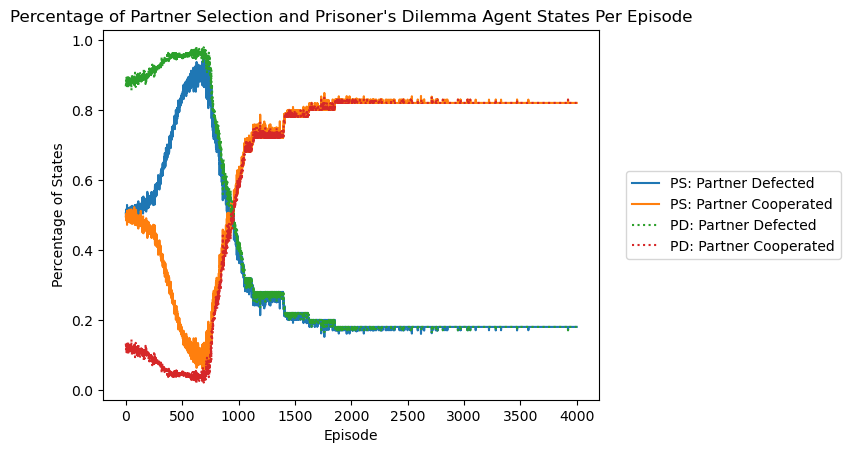

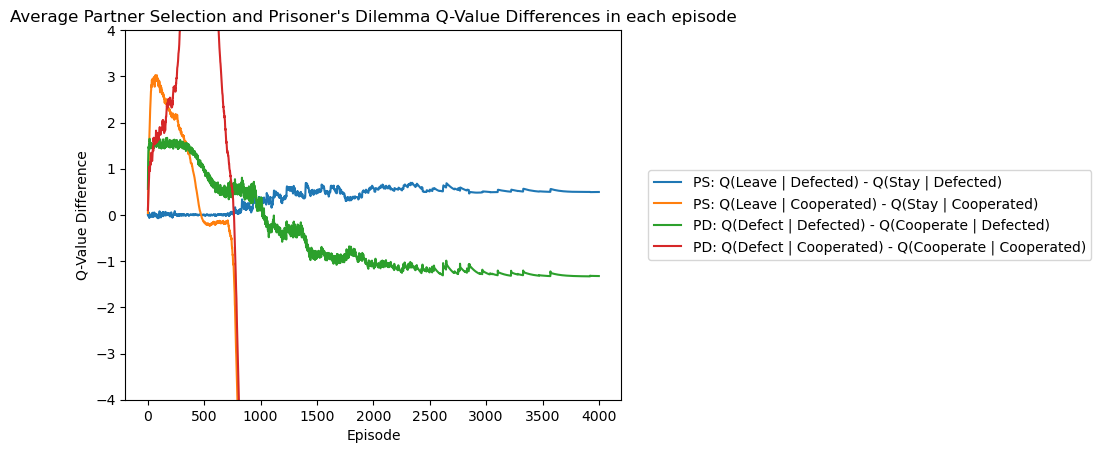

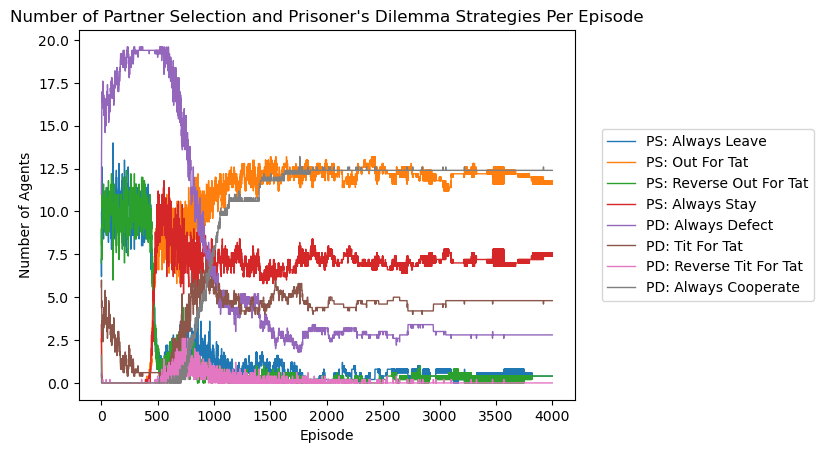

####################################################################################################
Disposition: 0.100000


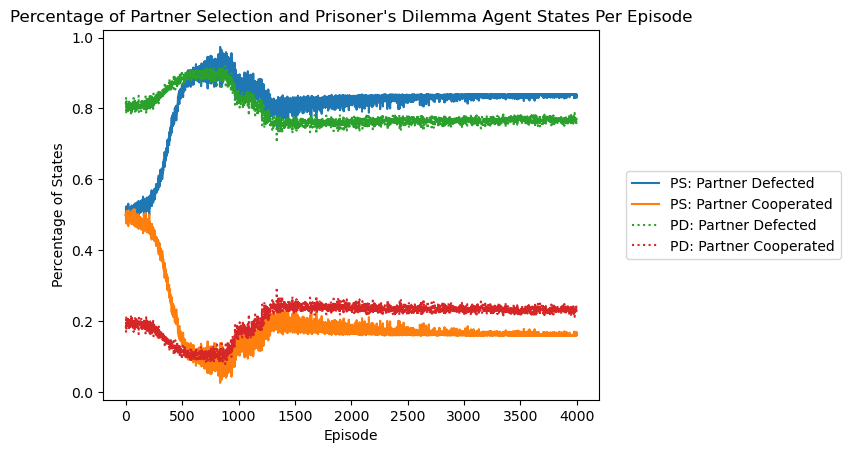

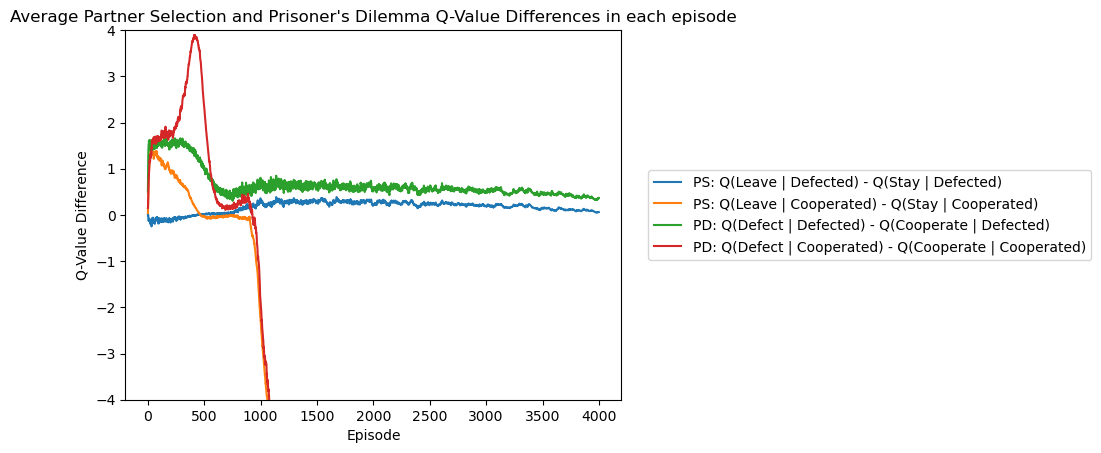

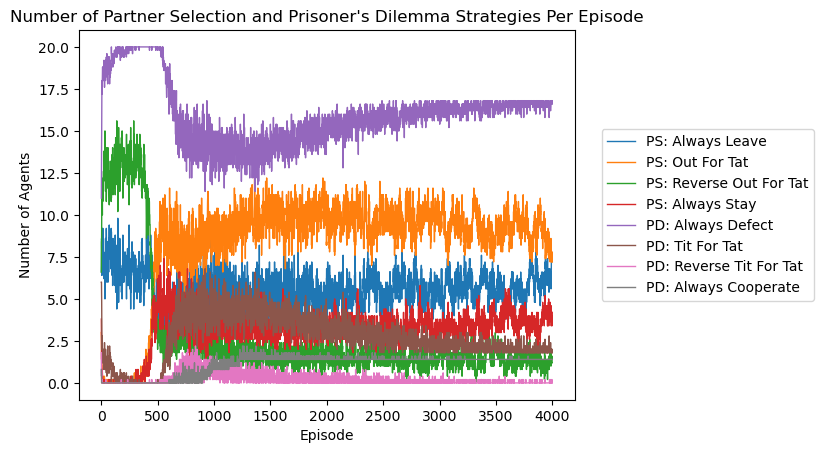

####################################################################################################
Disposition: 0.200000


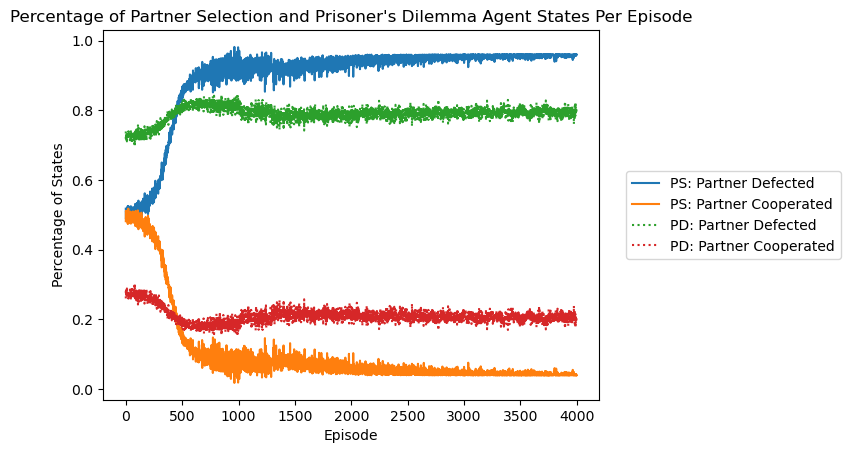

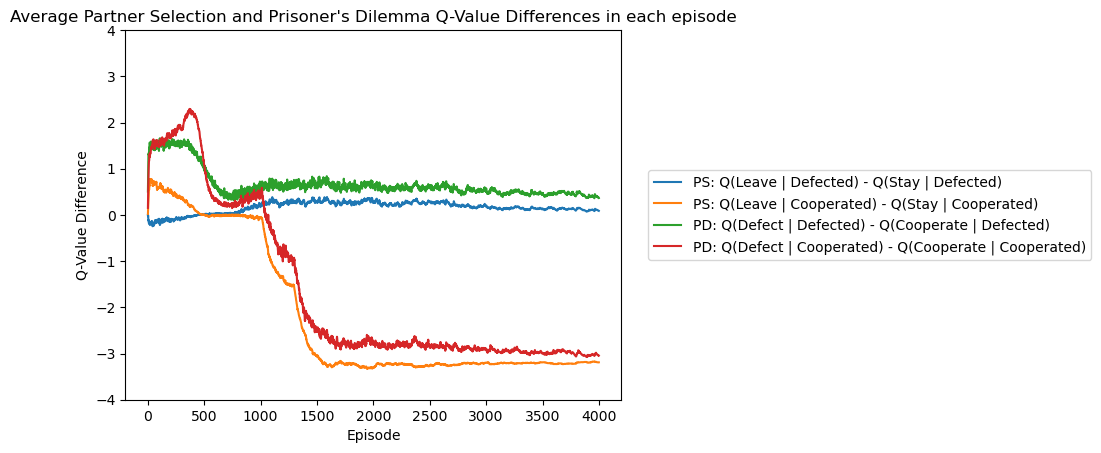

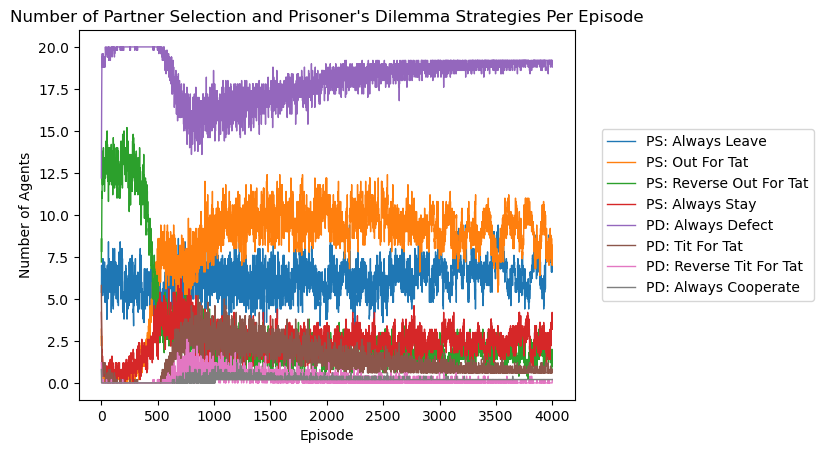

####################################################################################################
Disposition: 0.300000


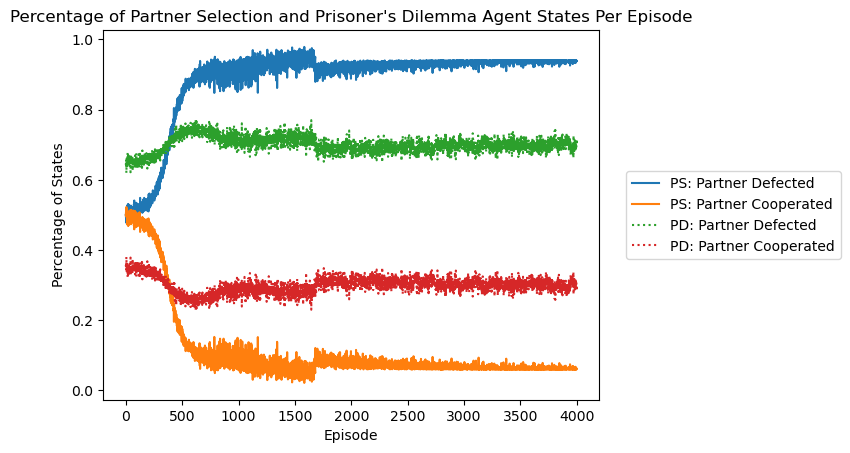

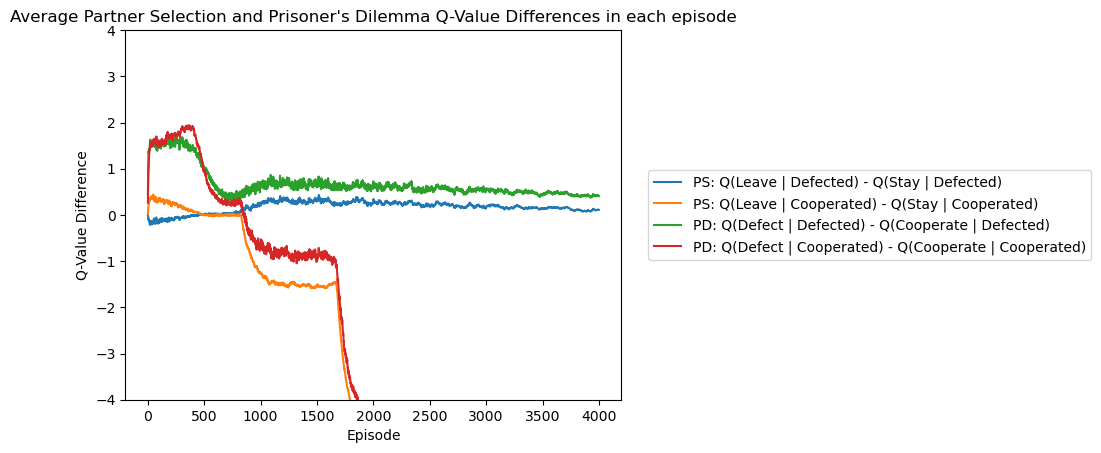

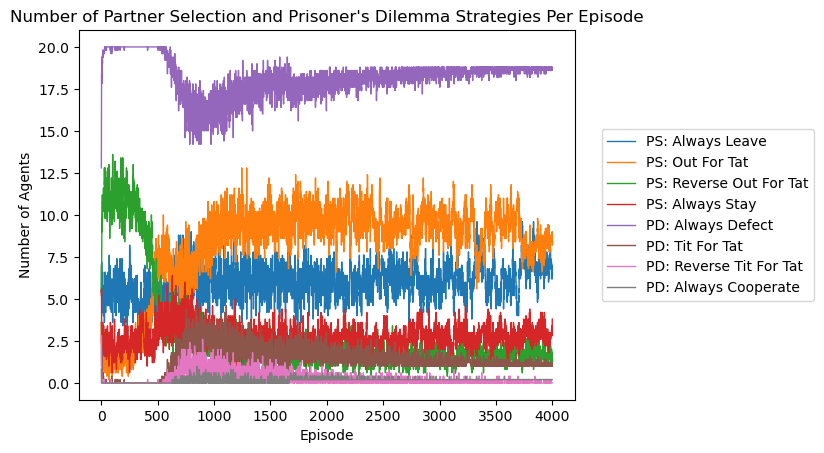

####################################################################################################
Disposition: 0.400000


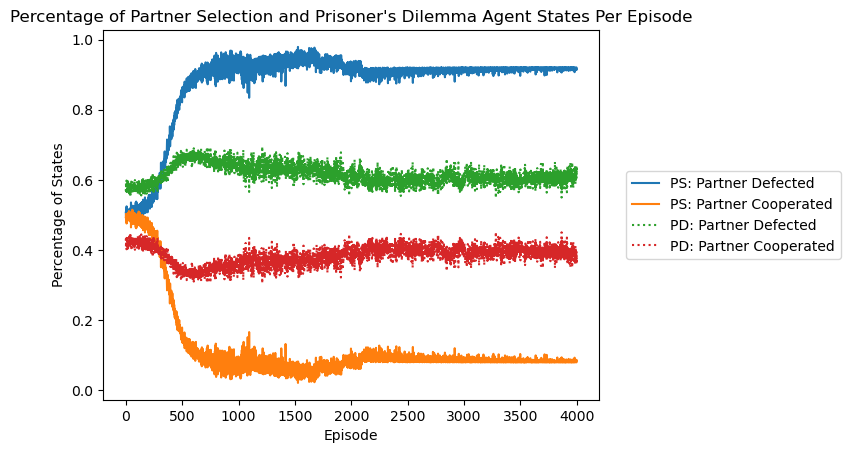

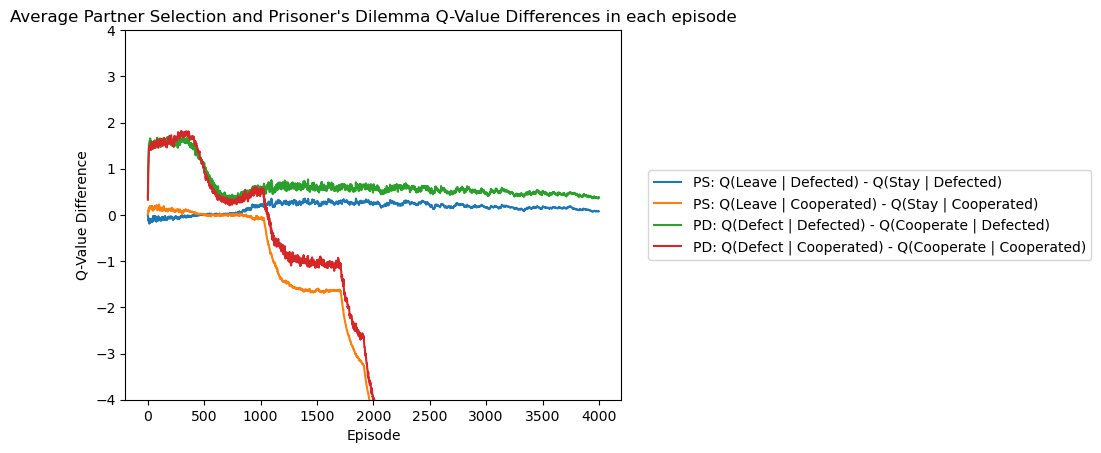

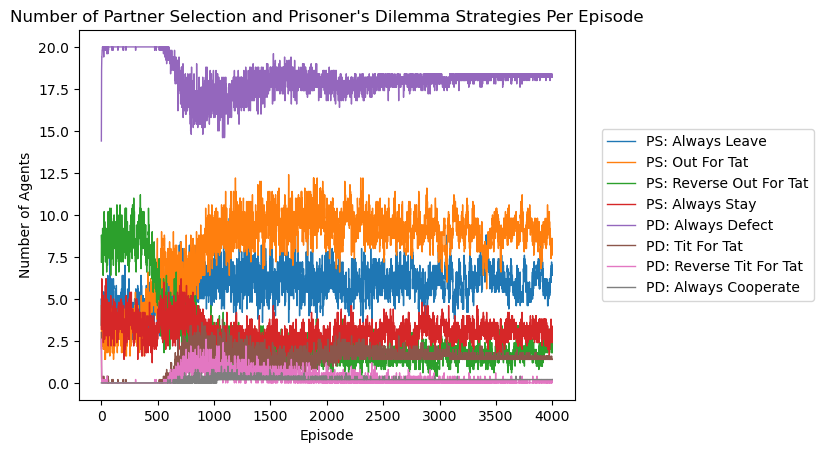

####################################################################################################
Disposition: 0.500000


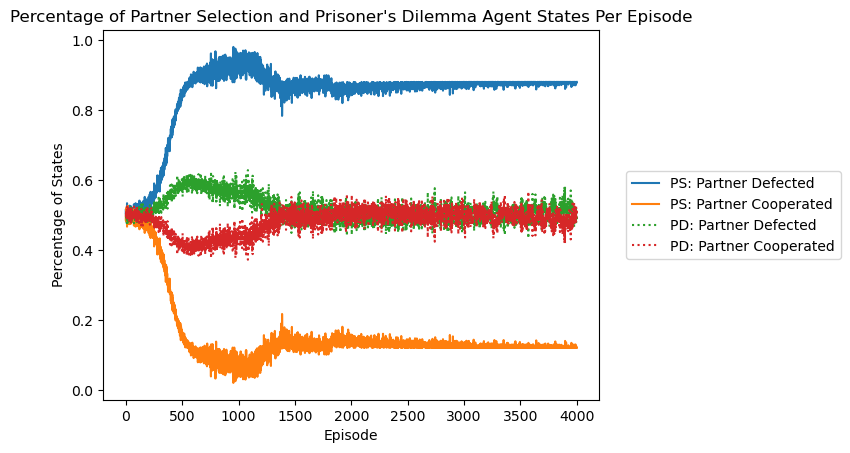

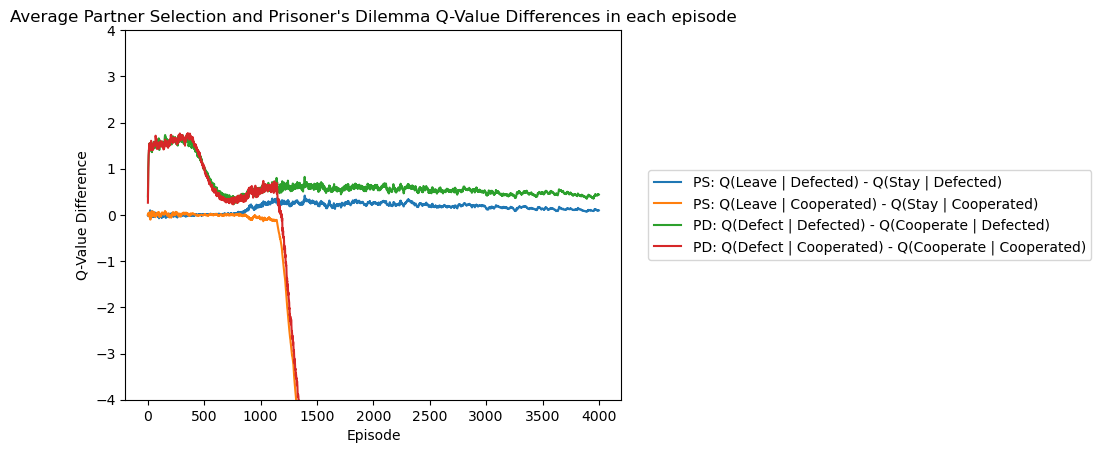

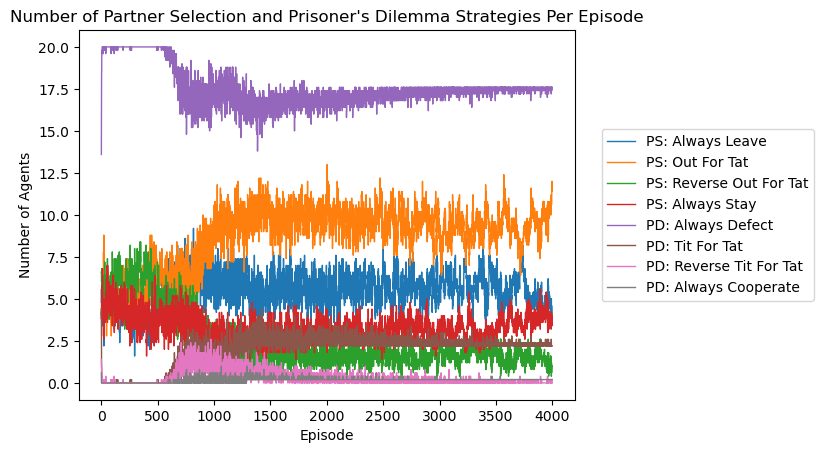

####################################################################################################
Disposition: 0.600000


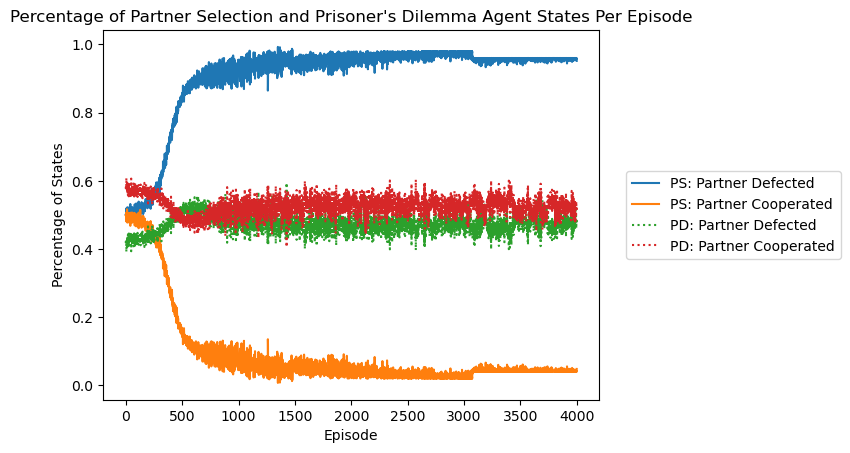

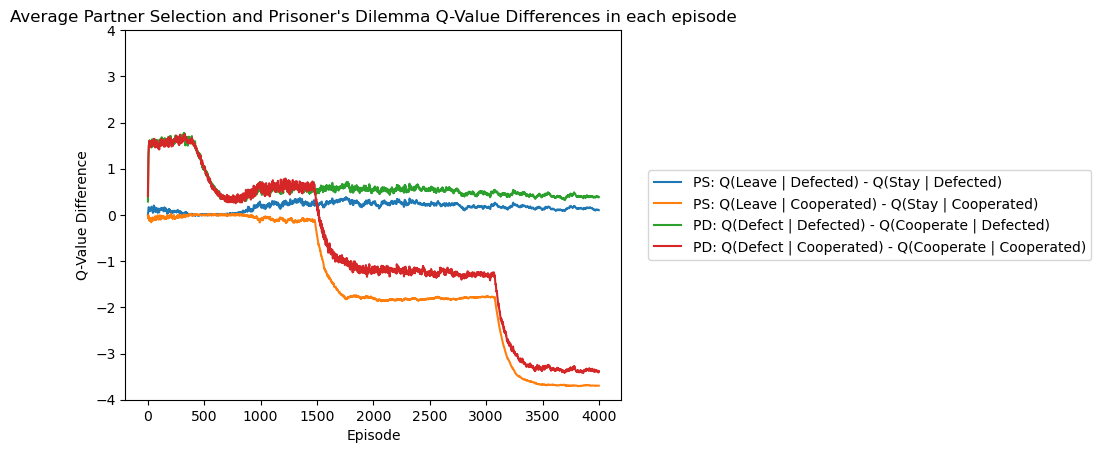

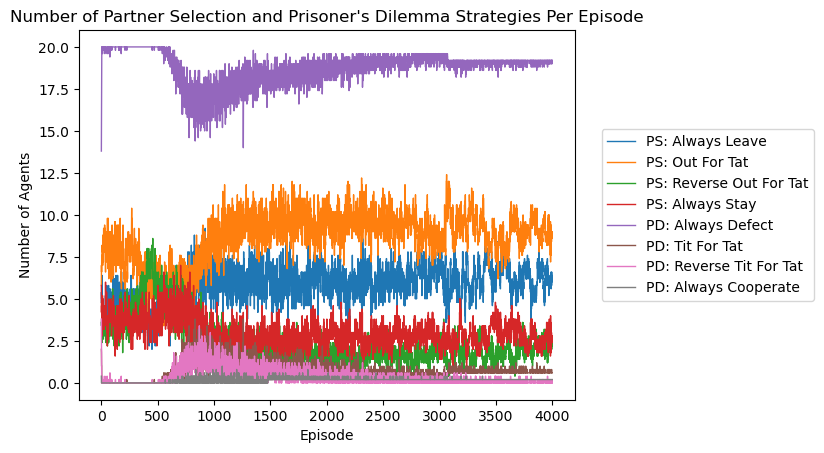

####################################################################################################
Disposition: 0.700000


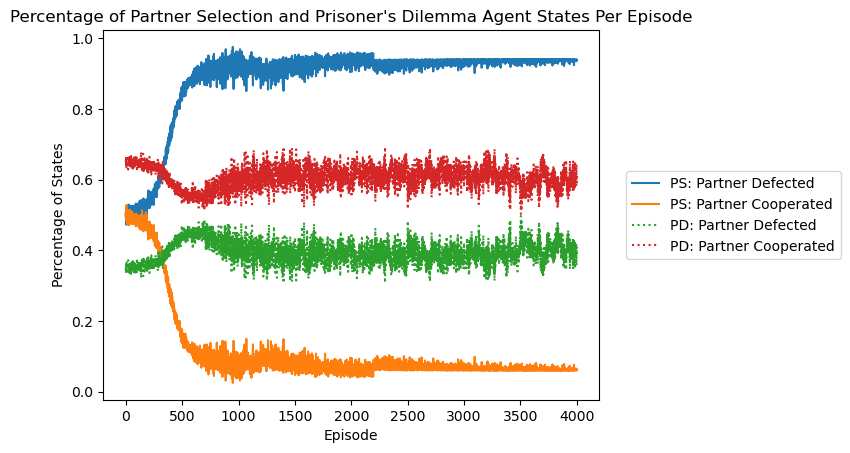

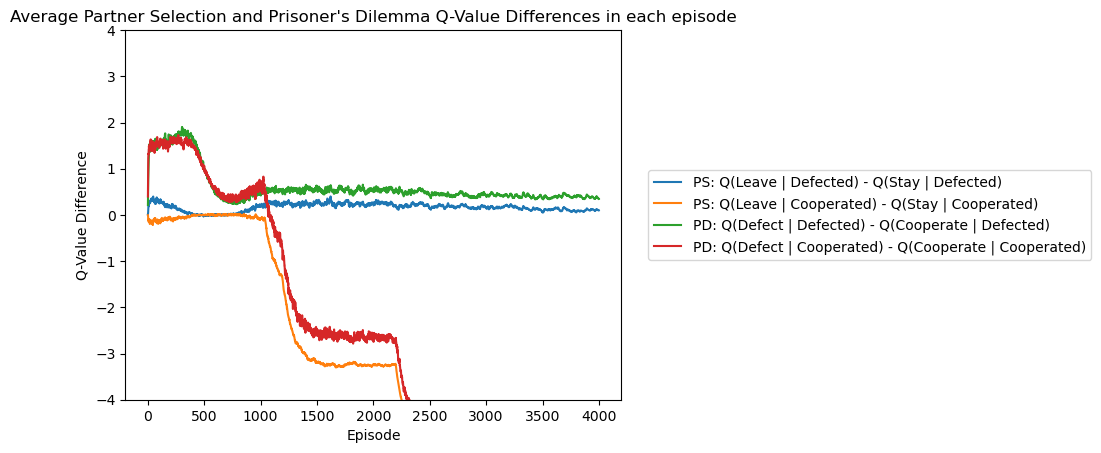

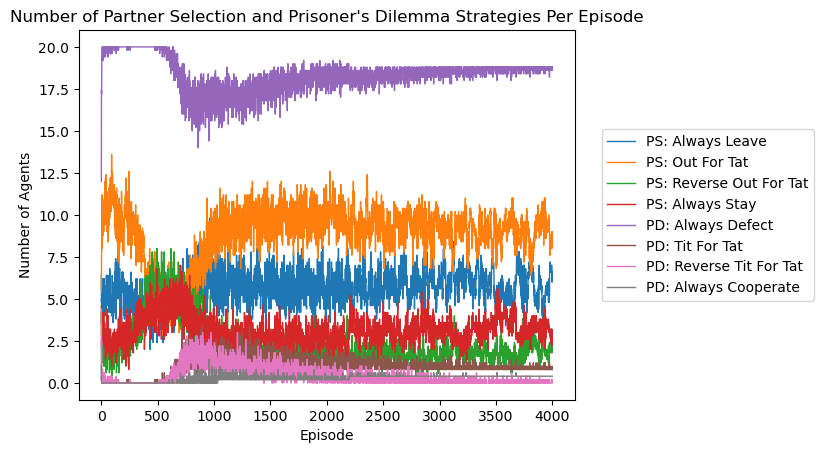

####################################################################################################
Disposition: 0.800000


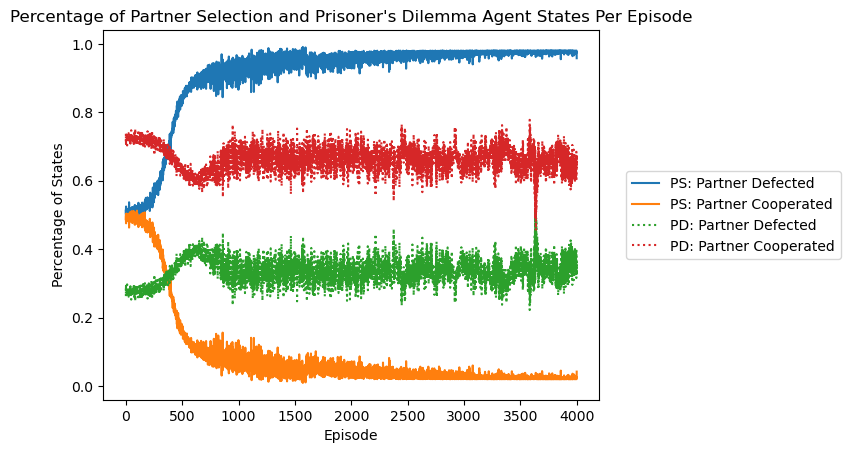

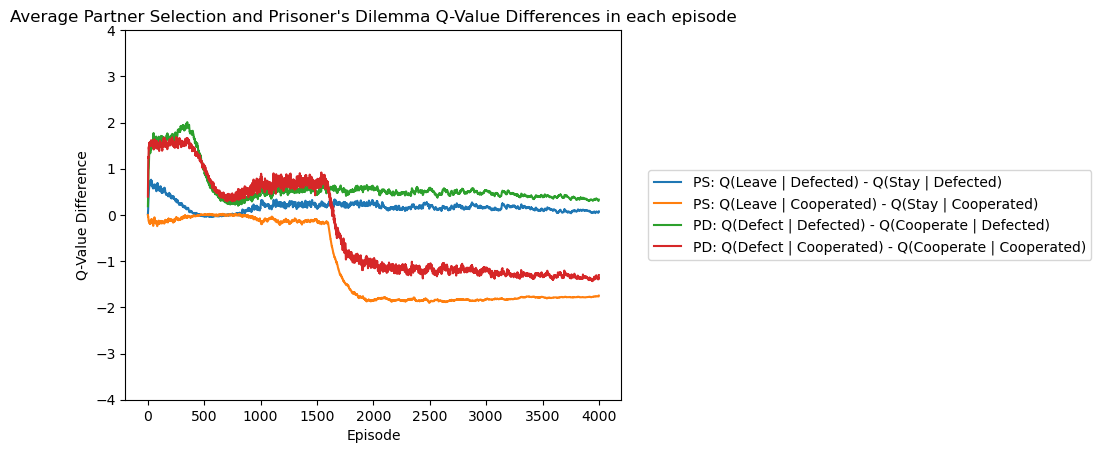

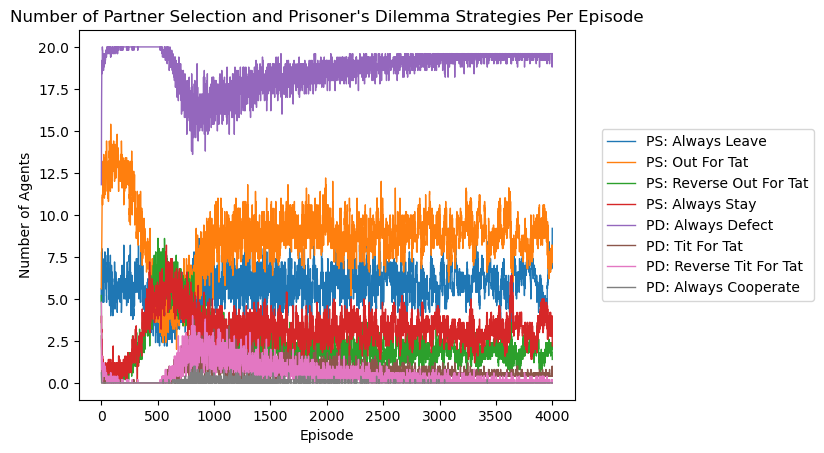

####################################################################################################
Disposition: 0.900000


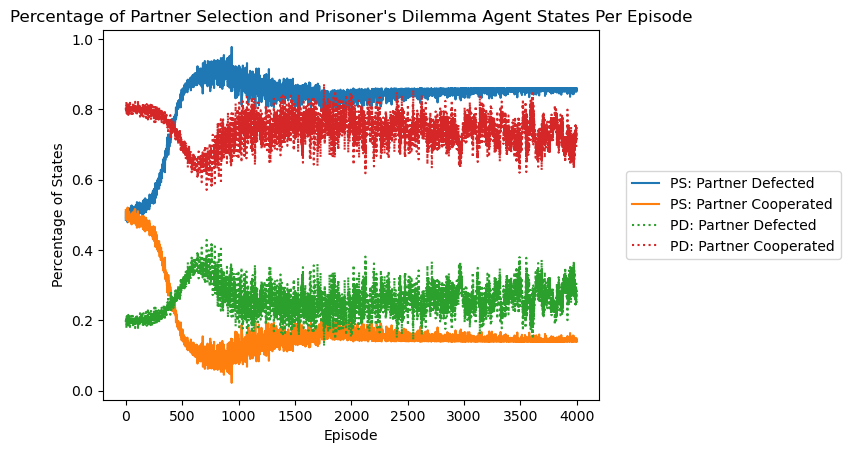

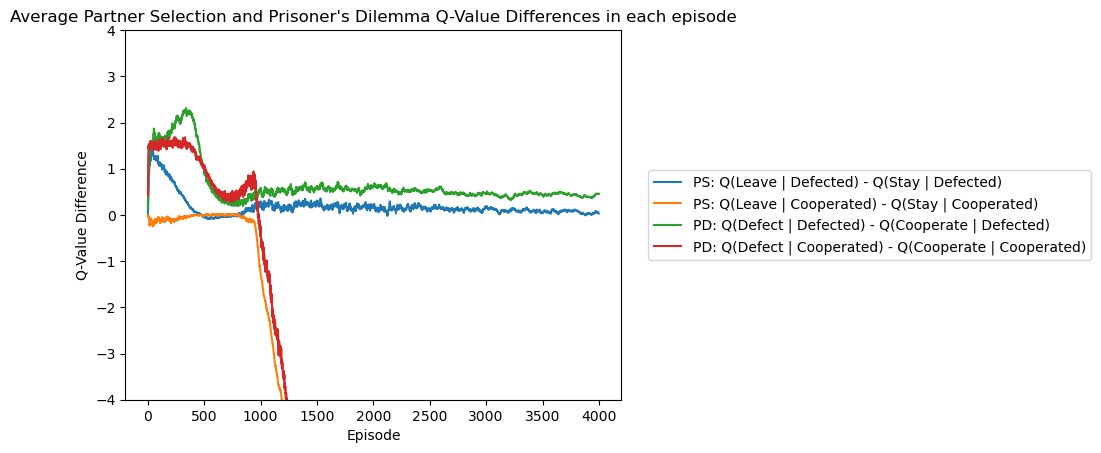

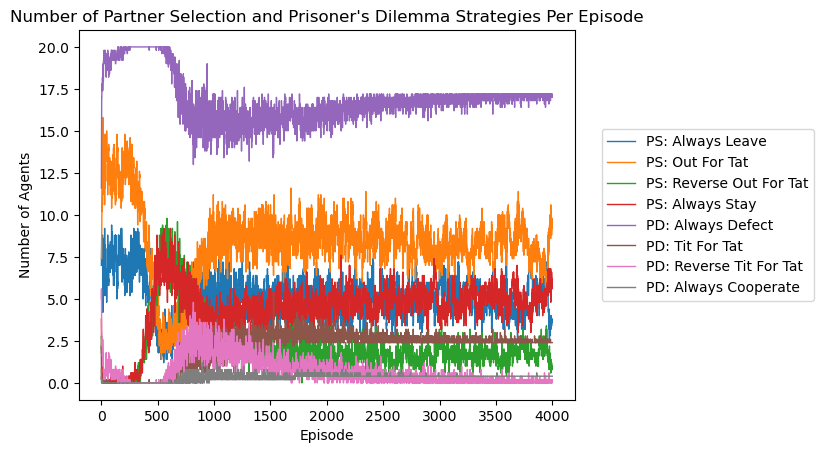

####################################################################################################
Disposition: 1.000000


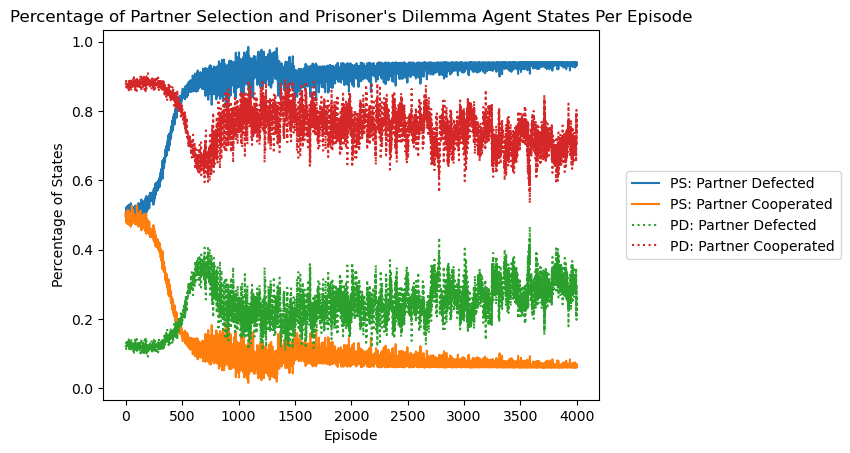

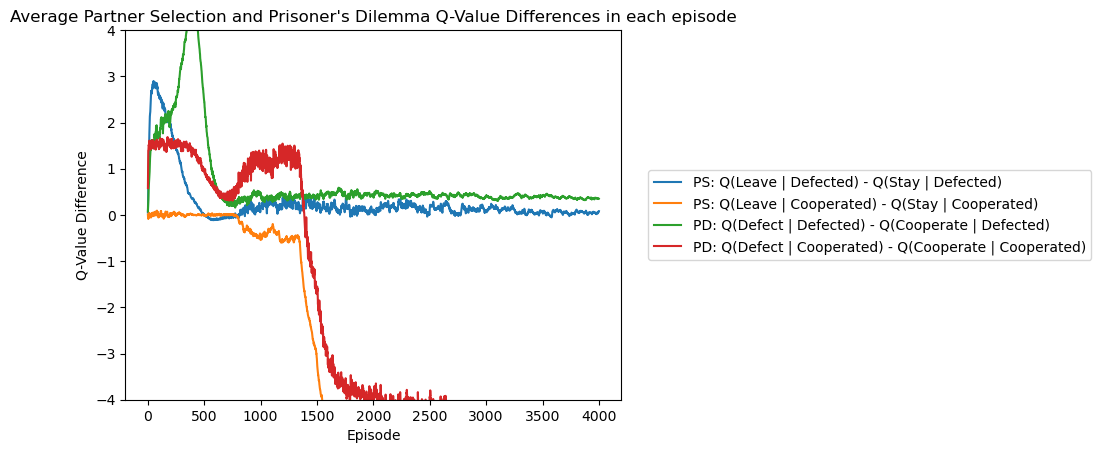

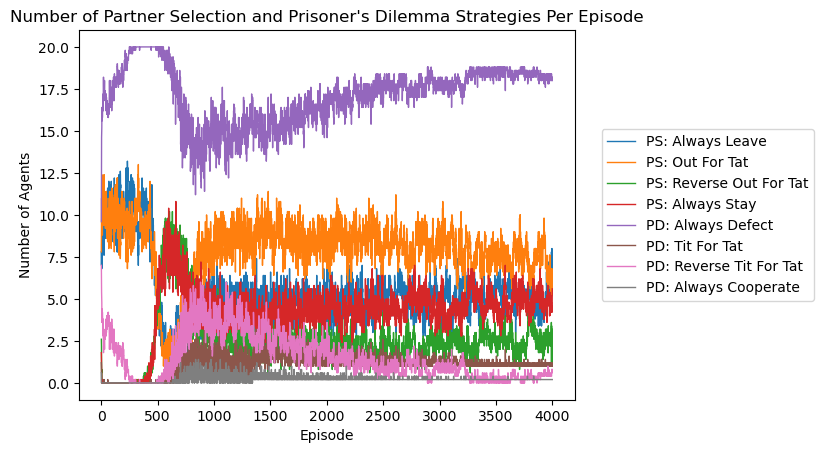

In [11]:
with open("disposition_q_learning_avg.pkl", "rb") as f:
    results = pickle.load(f)

temp_results = results
for temp, p_r in temp_results.items():
    print("#"*100)
    print("Disposition: %f" % temp)
    # print(f"Requires ~{.01/(1.0 - temp):.2f} episodes per 1 at 0.99")
    params = p_r["params"]
    results = p_r["output"]
    plot_percentage_of_states_per_episode(results)
    plot_average_qvalues(results)
    plot_average_q_differences(results)
    plot_strategies(results)

    # plot_mean_probabilities(results)

    # plot_average_qvalues(results, do_ps=False)
    # plot_average_q_differences(results, do_ps=False)
    # plot_strategies(results, do_ps= False)
    # plot_mean_probabilities(results, do_ps=False)
    
    # plot_strategy_combinations(results)